<center><font size = "10"> Week 12 - Network Simulation II and Extracellular recordings<center>
<center><font size = "8">Home Work <center>

<font size = "3">Please, write your group number and the names and surnames of the group members here
<br>Group number:
<br>Group member 1:
<br>Group member 2:
<br>Group member 3:
    
__IMPORTANT:__<font size = "3"> Exercises in <font color='red'>red</font> are mandatory assignments to be delivered by next Monday before 23:59.


In [39]:
!nrnivmodl

/opt/jlab-env/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/home/NX450/Tutorial_12-20241201
Mod files: "./vecevent.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.so
Successfully created x86_64/special


## Import libraries and classes

In [40]:
%matplotlib inline

import random
import itertools
import numpy as np
import quantities as pq
import matplotlib.pyplot as plt
import elephant.statistics as elstat
from neuron import h, gui
from neo import SpikeTrain

from elephant.conversion import BinnedSpikeTrain
import elephant.spike_train_correlation as elstc

from itertools import permutations
from scipy.signal import find_peaks
from matplotlib.collections import PolyCollection

# Load external files & initialize
h.load_file("stdrun.hoc")
h.stdinit()

0.0

In [41]:
class Cell:
    def __init__(self, filename, name, cell_type):
        self.name = name
        self.type = cell_type
        self.synapses = []
        self.build_morphology(filename)
        self.biophysics()

    def build_morphology(self, filename):
        h.load_file("import3d.hoc")
        h.load_file("stdlib.hoc")
        # morph_reader = h.Import3d_Neurolucida3()
        morph_reader = h.Import3d_SWC_read()
        morph_reader.input(filename)
        i3d = h.Import3d_GUI(morph_reader, 0)
        i3d.instantiate(
            self
        )  # Notice this change to be able to instantiate several cells

    def biophysics(self):
        for sec in h.allsec():
            sec.Ra = 100  # Axial resistance in Ohm * cm
            sec.cm = 1  # Membrane capacitance in micro Farads / cm^2
            sec.insert("pas")
            for seg in sec:
                seg.pas.g = 0.00003
                seg.pas.e = -75

        # Insert passive current in the dendrite
        for sec in self.soma:
            sec.insert("hh")
            for seg in sec:
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2

        if hasattr(self, "apic"):
            for sec in self.apic:
                sec.insert("hh")
                for seg in sec:
                    seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                    seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2

        for sec in self.dend:
            sec.insert("hh")
            for seg in sec:
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2

        for sec in self.axon:
            sec.insert("hh")
            for seg in sec:
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2

In [42]:
# connect two cells with an exponential synapse at given locations
# returns the netcon
def connect(
    source,
    target,
    weight=None,
    delay=5,
    source_sec=None,
    source_neurite="axon",
    target_sec=None,
    target_neurite="dend",
):
    rng = np.random.default_rng()

    if weight is None:
        weight = rng.uniform()  # random weight

    target_neurite_ = getattr(target, target_neurite)
    if target_sec is None:
        target_sec = rng.integers(0, len(target_neurite_))  # random dendritic section

    source_neurite_ = getattr(source, source_neurite)
    if source_sec is None:
        source_sec = rng.integers(0, len(source_neurite_))  # random axonal section

    target_syn = h.ExpSyn(target_neurite_[target_sec](0.5))
    target.synapses.append(target_syn)  # store synapse

    netcon = h.NetCon(
        source_neurite_[source_sec](0.5)._ref_v,
        target_syn,
        sec=source_neurite_[source_sec],
    )
    netcon.weight[0] = weight
    netcon.delay = delay
    # print(
    #     f"Connected cells {source.name} -> {target.name} with weight {weight} and delay {delay}, from {source_neurite}[{source_sec}] to {target_neurite}[{target_sec}]"
    # )

    return netcon


def spike_detector(voltage, threshold):
    # convert Neuron recording (voltage) to list
    voltage_read = []
    for v in voltage:
        voltage_read.append(v)
    # peak locations
    spike_time, _ = find_peaks(voltage_read, height=threshold)
    return spike_time


def generate_irregular_spiketrain(t_start, size):
    """generates irregular spike train with random inter-spike interval from the range between 10 and 50 ms"""
    stim_times = [t_start]
    for t in np.arange(size):
        n = np.random.randint(10, 50)
        step = stim_times[-1] + n
        stim_times.append(step)

    return stim_times


def place_exp_synapse(cell, tau=2, section=None):
    if not section:
        section = random.randint(0, len(cell.dend) - 1)
    synapse = h.ExpSyn(cell.dend[section](0.5))
    synapse.tau = tau  # ms
    # print(f"Stimulus apply in basal section num {section} of {cell.name}")
    return synapse, section


def simulate(cells, tstop=600):
    """This function simulates the network and return recordings of all cells
    put as argument."""
    cell_recordings = []
    for cell in cells:
        recording = cell
        cell_recordings.append(recording)

    soma_recordings = []
    for recording in cell_recordings:
        soma_v = h.Vector().record(recording.soma[0](0.5)._ref_v)
        soma_recordings.append(soma_v)

    time = h.Vector().record(h._ref_t)

    h.finitialize(-65)
    h.continuerun(tstop)

    return time, soma_recordings

# <font color= 'red'>Ex 1:</font> Network activity analysis 

<font size='3'> Load the five morphology reconstructions assigned to your group in week 7, using the class `Cell` defined in the tutorials. 
Connect the neurons with following weights:
- `w(Pyr - Pyr) = 1`
- `w(Pyr - Int) = 1`
- `w(Int - Pyr) = -0.01`
- `w(Int - Int) = -0.01`

<font size='3'>Add exponential synapses to random section of the basal dendrite of each cell (synapse `weight = 1.0` and `tau = 2`). Connect different Poisson spike trains to each of the exponential synapses (NOTE: this is asynchronous stimulation, a different poisson for each cell).   Run the simulation for 300 ms,  and show the voltage and spike plots neurons and Poisson input.

<font size='3'>Using the `elephant` library calculate:
    
<font size='3'>1. Pairwise __correlation coefficients__ and __covariance__ between the pairs of 5 neurons. Describe how covariance and correlation coefficient are calculated for neural spiking data. 

<font size='3'>2. the features MFR, CV, ISI for each cell. Compare these between the pyramidal cells and interneurons using a box plot. 
  
<font size='3'>Hint: Make sure to represent both spike trains in ms.

For each feature and each pair of cells, plot the normalized difference in the feature against their correlation coefficient on a scatter plot.
    
<font size='3'><font color= 'red'>[2.5pts]</font>

<span style="color:purple">
<font size='3'> 
    

## **Grading**: 
- [0.5 pt] for simulation setup
- [1 pt] for calculation and visualization of covariance and correlation
- [1 pt] for explaining covariance and correlation
- [0.5 pt] for explanation of differences between covariance and correlation 

[/2.5 pt]
</span>

## Answer

Correlation coefficient and covariance are calulated by first splitting the spiketrains into bins of particular time lengths.
The number of spikes in each bin for each cell can then be treated as a vector, and covariance and correlation coeffficient calculated by the following formulae:

$Cov(x, y) = \frac{(x - \bar{x}) \dot (y - \bar{y})}{N-1}$ where $\bar{a}$ represents the mean of vector $a$ and $N$ is the sample size (in this case, number of time bins)

$\rho(x, y) = \frac{Cov(x, y)}{\sigma_x \sigma_y} $ where $\sigma_a$ represents the covariance of a vector $a$

In [43]:
Pyr1 = Cell("Pyr_01.swc", "Pyr1", "Pyr")
Pyr2 = Cell("Pyr_02.swc", "Pyr2", "Pyr")
Pyr3 = Cell("Pyr_03.swc", "Pyr3", "Pyr")
Int1 = Cell("Int_01.swc", "Int1", "Int")
Int2 = Cell("Int_02.swc", "Int2", "Int")
cells_Pyr = [Pyr1, Pyr2, Pyr3]
cells_Int = [Int1, Int2]
cells = cells_Pyr + cells_Int

In [44]:
recording_cells = [Pyr1, Pyr2, Pyr3, Int1, Int2]
recording_cells_name = [Pyr1.name, Pyr2.name, Pyr3.name, Int1.name, Int2.name]

In [45]:
syn_weight = 1.0

netcons = []  # save the netcons in case we want to modify them later

for n, (pre_neuron, post_neuron) in enumerate(permutations(cells, 2)):
    if pre_neuron.type == "Pyr" and post_neuron.type == "Pyr":
        nc = connect(pre_neuron, post_neuron, weight=1.0)
        netcons.append(nc)
    elif pre_neuron.type == "Pyr" and post_neuron.type == "Int":
        nc = connect(pre_neuron, post_neuron, weight=1.0)
        netcons.append(nc)
    elif pre_neuron.type == "Int" and post_neuron.type == "Pyr":
        nc = connect(pre_neuron, post_neuron, weight=-0.01, target_neurite="soma")
        netcons.append(nc)
    elif pre_neuron.type == "Int" and post_neuron.type == "Int":
        nc = connect(pre_neuron, post_neuron, weight=-0.01, target_neurite="soma")
        netcons.append(nc)

synapses = []
for cell in cells:
    syn, _ = place_exp_synapse(cell, section=5)
    synapses.append(syn)


stimulators = []
connections = []
spike_trains = []
for syn in synapses:
    spike_train = np.random.exponential(20,size=1000).cumsum()
    spike_train = spike_train[spike_train < 300]
    spike_trains.append(spike_train)
    spikes_vector = h.Vector(spike_train)

    stimulators.append(h.VecStim())
    stimulators[-1].play(spikes_vector)

    connection = h.NetCon(stimulators[-1], syn)
    connection.weight[0] = syn_weight
    connections.append(connection)

time, recordings = simulate(cells)

In [47]:
spikes = []
for trace, cell in zip(recordings, cells):
    spikes.append(spike_detector(trace, -20.0))

spikes = [np.array(spike) * 0.025 for spike in spikes]

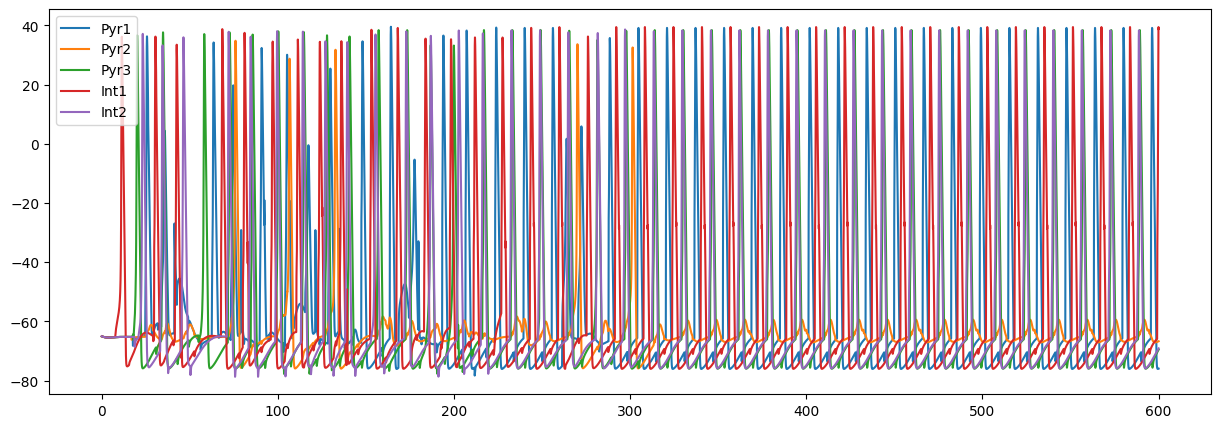

In [48]:
plt.figure(figsize=(15, 5))

for trace, cell in zip(recordings, cells):
    plt.plot(time, trace, label=cell.name)

plt.legend()

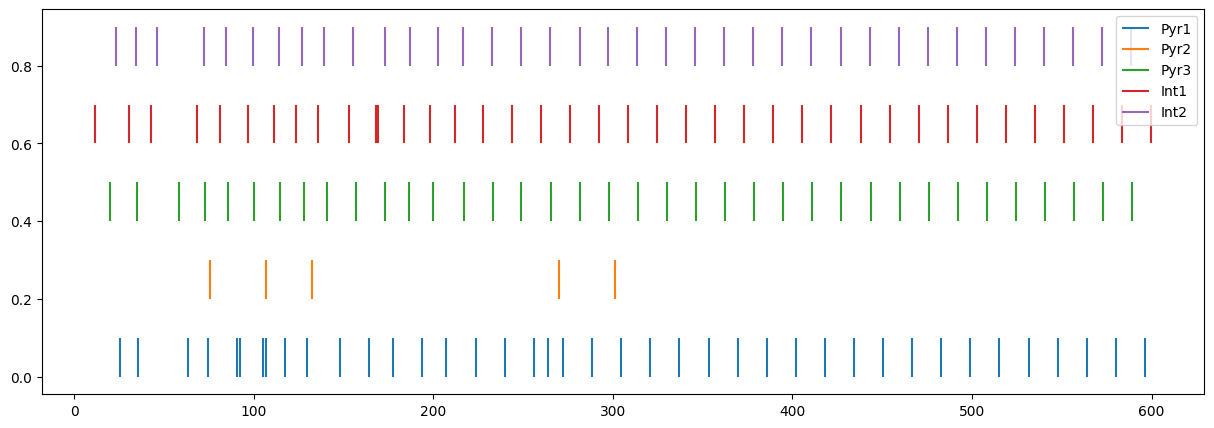

In [49]:
plt.figure(figsize=(15, 5))
for n, (spiketrain, cell) in enumerate(zip(spikes, cells)):
    plt.vlines(
        spiketrain, ymin=n * 0.2, ymax=n * 0.2 + 0.1, label=cell.name, color=f"C{n}"
    )

plt.legend()

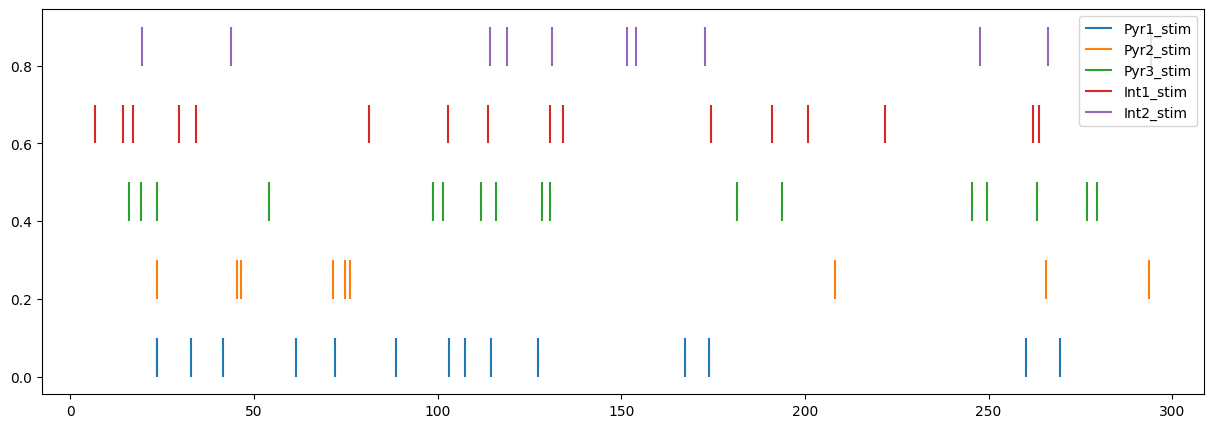

In [50]:
plt.figure(figsize=(15, 5))
for n, (spiketrain, cell) in enumerate(zip(spike_trains, cells)):
    plt.vlines(
        spiketrain,
        ymin=n * 0.2,
        ymax=n * 0.2 + 0.1,
        label=cell.name + "_stim",
        color=f"C{n}",
    )

plt.legend()

In [51]:
def extract_spiketrains_features(spikes):
    ISI = np.array([])
    FR = []
    CV = []

    for spiketrain in spikes:
        fr = elstat.mean_firing_rate(spiketrain) * 1000
        isi = elstat.isi(spiketrain)
        cv = elstat.cv(isi)
        FR.append(fr)
        CV.append(cv)
        ISI = np.append(ISI, isi)

    CV = np.array(CV)
    FR = np.array(FR)

    return {"CV": CV, "FR": FR, "ISI": ISI}

In [52]:
values = extract_spiketrains_features(spikes)

([<matplotlib.axis.XTick at 0x795251c83590>,
 [Text(1, 0, 'Pyr'), Text(2, 0, 'Int')])

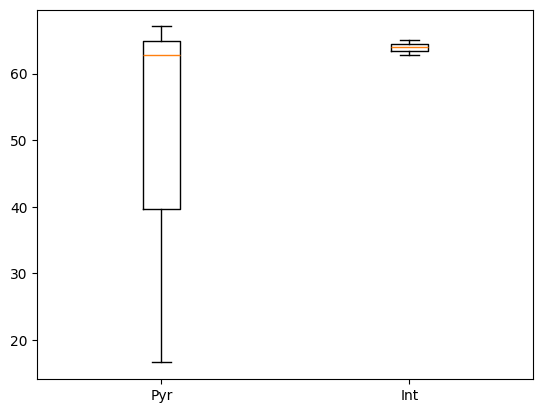

In [53]:
plt.boxplot([values['FR'][:3], values['FR'][3:]])#, label='Pyr')
plt.xticks([1, 2], labels=['Pyr', 'Int'])

### Correlation coefficient and covariation

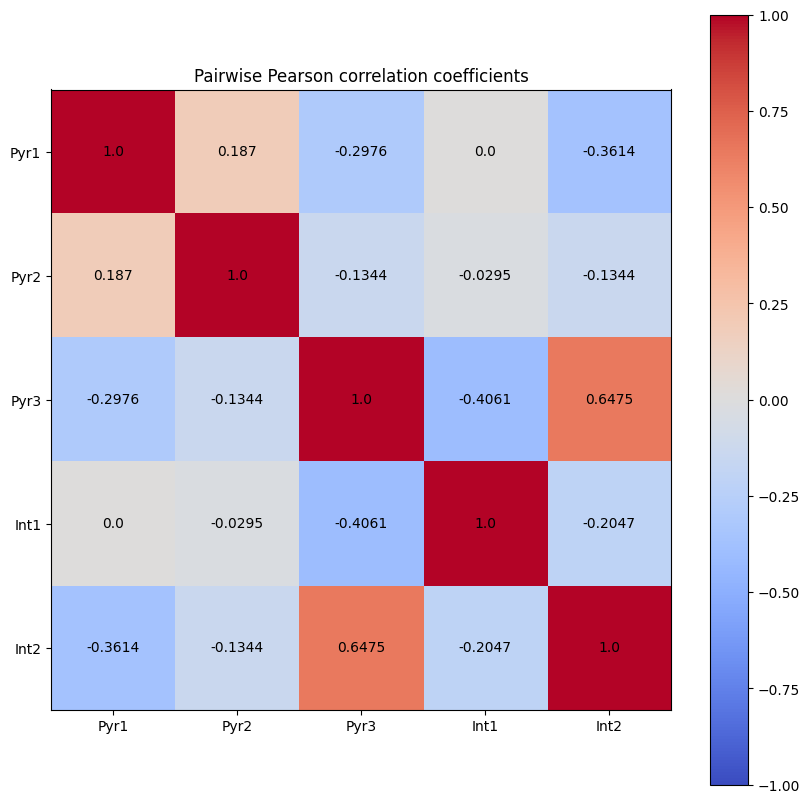

In [55]:
sim_tstop = 600

# We bin the spikes in both cell and stim spikes
allspikes = [SpikeTrain(x * pq.ms, t_stop=sim_tstop * pq.ms) for x in spikes]
binned_spikes = BinnedSpikeTrain(allspikes, bin_size=10 * pq.ms)  # 10 ms bin
# Correlation coefficient matrix between all spike trains
cc = elstc.corrcoef(binned_spikes)

fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(cc, cmap="coolwarm", vmin=-1.0, vmax=1.0, origin="upper")

# We want to show all ticks...
ax.set_xticks(np.arange(len(recording_cells_name)))
ax.set_yticks(np.arange(len(recording_cells_name)))
# ... and label them with the respective list entries
ax.set_xticklabels(recording_cells_name)
ax.set_yticklabels(recording_cells_name)

# Loop over data dimensions and create text annotations.
for i in range(len(recording_cells_name)):
    for j in range(len(recording_cells_name)):
        text = ax.text(
            j, i, np.round(cc[i, j], 4), ha="center", va="center", color="black"
        )

ax.set_title("Pairwise Pearson correlation coefficients")
plt.colorbar(im)
plt.show()

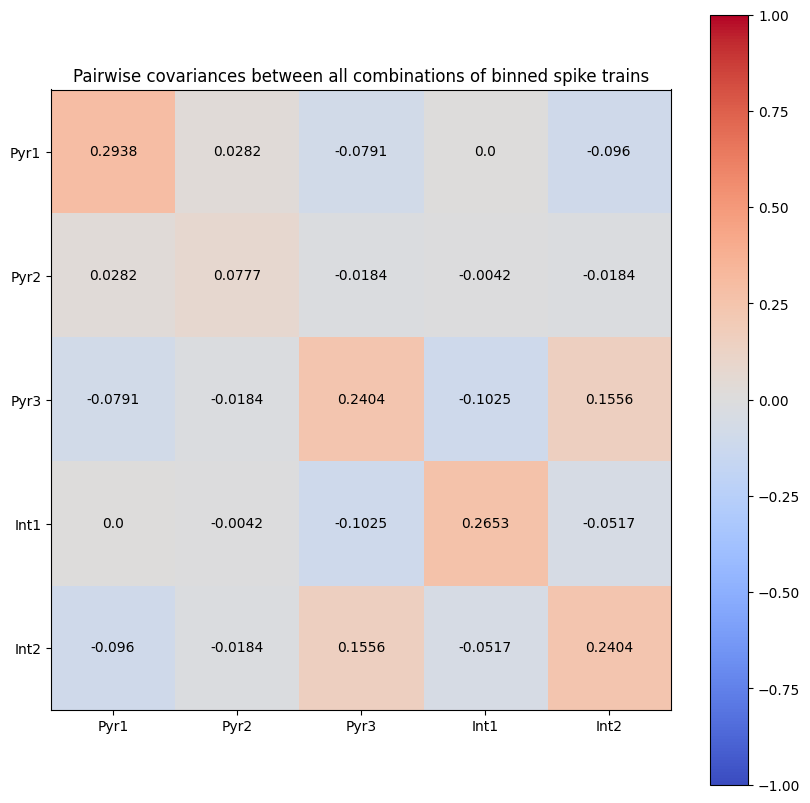

In [56]:
cv = elstc.covariance(binned_spikes)

fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(cv, cmap="coolwarm", vmin=-1.0, vmax=1.0, origin="upper")
# We want to show all ticks...
ax.set_xticks(np.arange(len(recording_cells_name)))
ax.set_yticks(np.arange(len(recording_cells_name)))
# ... and label them with the respective list entries
ax.set_xticklabels(recording_cells_name)
ax.set_yticklabels(recording_cells_name)

# Loop over data dimensions and create text annotations.
for i in range(len(recording_cells_name)):
    for j in range(len(recording_cells_name)):
        text = ax.text(
            j, i, np.round(cv[i, j], 4), ha="center", va="center", color="black"
        )

ax.set_title("Pairwise covariances between all combinations of binned spike trains")


plt.colorbar(im)
plt.show()

# <font color= 'red'>Ex 2:</font> Extracellular field

<font size='3'>Choose one pyramidal cell and one inhibitory cell from your set of cells. Run the code from tutorial 02 for each of the cells and compare the resulted response field for each of them. Explain what differences you see in the shapes and timecourses of the electrical fields recorded. What do these differences suggest about the patterns of transmembrane currents in the cells?

<font size='3'><font color= 'red'>[2.5 pts]</font>   



<span style="color:purple">
<font size='3'> 
    

## **Grading**: 
- [1 pt] for correct simulation setup and visualization
- [1 pt] for plots explanation

[/2.5 pt]    
</span>

## Answers:

Looking at the plots of the evolution over time of the extracellular potential at the 2 recording electrodes (the green and the blue ones), we can first note several things:
- after the delivery of the synaptic current at the red location, the extracellular potential modification is longer lasting for the pyramidal cell than for the inhibitory one at these points of the space. Indeed, the curves of the evolution over time of the extracellular potential at the 2 recording electrodes do not exhibit the same shape (especially the green ones), and are wider for the excitatory cell than for the inhibitory one, indicating a faster recovering around the latter. Thus we can conclude here that for the inhibitory cell, the return to the initial state is faster. And this is in agreement with the fact that inhibitory cells generally exhibit a faster repolarization after a spike.
- concerning the amplitude, we can first note that for both cells, there is a decrease in extracellular potential at the level of the green electrodes and an increase at the level of the blue electrodes. Indeed, this is coherent since there are almost no dendrites near to the green electrodes, whereas the region next to the blue electrodes is closer to the soma and is very dense in dendrites.
Then, we can observe that for the blue recording electrode, the maximum amplitude of the extracellular potential curve is significantly higher for the inhibitory cell than for the excitatory one. Indeed, the blue electrode records a maximum potential of roughly 25 nV for the inhibitory cell, which is approximately 5 times larger than for the excitatory cell. At the green recording electrode, the maximum amplitudes differences are however less important between the 2 cells. But as these electrodes are located at different relative distances from the synapse, these differences in amplitudes between the 2 cells at single points are not very relevant and we should more rely on the overall field lines of extracellular potential to assess the variations. 

So regarding now more generally the evolution over space of the extracellular potential, we can note that the response seems to be stronger around the synapse location for the excitatory cell than for the inhibitory one. The augmentation of the extracellular potential seems also to be more spread for the pyramidal cell and more concentrated in space for the inhibitory neuron.

Another thing they may note is that the LFP follows the cellular morphology to an extent.

In [5]:
import LFPy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection

--No graphics will be displayed.


In [6]:
# Define cell parameters
int_parameters = {
    "morphology": "Int_02.swc",  # from Mainen & Sejnowski, J Comput Neurosci, 1996
    "cm": 1.0,  # membrane capacitance
    "Ra": 150.0,  # axial resistance
    "v_init": -65.0,  # initial crossmembrane potential
    "passive": True,  # turn on NEURONs passive mechanism for all sections
    "passive_parameters": {"g_pas": 1.0 / 30000, "e_pas": -65},
    "nsegs_method": "lambda_f",  # spatial discretization method
    "lambda_f": 100.0,  # frequency where length constants are computed
    "dt": 2.0 ** -3,  # simulation time step size
    "tstart": 0.0,  # start time of simulation, recorders start at t=0
    "tstop": 100.0,  # stop simulation at 100 ms.
}
int_rotations = 4.71239, 0.0, 4.71239

# Define cell parameters
pyr_parameters = {
    "morphology": "Pyr_02.swc",  # from Mainen & Sejnowski, J Comput Neurosci, 1996
    "cm": 1.0,  # membrane capacitance
    "Ra": 150.0,  # axial resistance
    "v_init": -65.0,  # initial crossmembrane potential
    "passive": True,  # turn on NEURONs passive mechanism for all sections
    "passive_parameters": {"g_pas": 1.0 / 30000, "e_pas": -65},
    "nsegs_method": "lambda_f",  # spatial discretization method
    "lambda_f": 100.0,  # frequency where length constants are computed
    "dt": 2.0 ** -3,  # simulation time step size
    "tstart": 0.0,  # start time of simulation, recorders start at t=0
    "tstop": 100.0,  # stop simulation at 100 ms.
}
pyr_rotations = 4.71239+np.pi, 0.0, 4.71239

In [7]:
def run_expr(cell_parameters, rotation):
    # Create cell
    cell = LFPy.Cell(**cell_parameters)
    # Align cell
    xr, yr, zr = rotation
    cell.set_rotation(x=xr, y=yr, z=zr)  # same rotation angles as in tutorial 03

    
    synapse_parameters = {
        "idx": cell.get_closest_idx(x=-200.0, y=0.0, z=800.0),
        "e": 0.0,  # reversal potential
        "syntype": "ExpSyn",  # synapse type
        "tau": 5.0,  # synaptic time constant
        "weight": 0.1,  # synaptic weight
        "record_current": True,  # record synapse current
    }
    # Create a grid of measurement locations, in (mum)
    X, Z = np.mgrid[-700:701:50, -400:1201:50]
    Y = np.zeros(X.shape)

    # Define electrode parameters
    grid_electrode_parameters = {
        "sigma": 0.3,  # extracellular conductivity
        "x": X.flatten(),  # electrode requires 1d vector of positions
        "y": Y.flatten(),
        "z": Z.flatten(),
    }

    # Define electrode parameters
    point_electrode_parameters = {
        "sigma": 0.3,  # extracellular conductivity
        "x": np.array([-130.0, -220.0]),
        "y": np.array([0.0, 0.0]),
        "z": np.array([0.0, 700.0]),
    }

    synapse = LFPy.Synapse(cell, **synapse_parameters)
    synapse.set_spike_times(np.array([20.0]))
    # Run simulation, electrode object argument in cell.simulate

    # Create electrode objects
    grid_electrode = LFPy.RecExtElectrode(cell, **grid_electrode_parameters)
    point_electrode = LFPy.RecExtElectrode(cell, **point_electrode_parameters)
    cell.simulate(probes=[grid_electrode, point_electrode], rec_imem=True)
    fig = plt.figure(dpi=160)

    ax = fig.add_axes([0.4, 0.1, 0.55, 0.8], aspect="equal", frameon=False)
    cax = fig.add_axes([0.85, 0.4, 0.01, 0.2], frameon=False)

    LFP = np.max(np.abs(grid_electrode.data), 1).reshape(X.shape)
    im = ax.contour(X, Z, np.log10(LFP), 50, cmap="inferno", zorder=-2)
    # im = ax.contour(X, Z, LFP, 50, cmap="inferno", zorder=-2)
    cbar = fig.colorbar(im, cax=cax)
    cbar.set_label("$|\Phi(\mathbf{r}, t)|_\mathrm{max}$ (nV)")
    cbar.outline.set_visible(False)

    # get some log-linear tickmarks and ticklabels
    ticks = np.arange(np.ceil(np.log10(LFP.min())), np.floor(np.log10(LFP.max())))
    cbar.set_ticks(ticks)
    cbar.set_ticklabels(np.round(10.0 ** ticks * 1e6, decimals=1))  # mV -> nV

    # plot morphology
    zips = []
    for x, z in cell.get_idx_polygons():
        zips.append(list(zip(x, z)))
    polycol = PolyCollection(zips, edgecolors="none", facecolors="k")
    ax.add_collection(polycol)

    ax.plot([100, 200], [-400, -400], "k", lw=1, clip_on=False)
    ax.text(150, -470, r"100$\mu$m", va="center", ha="center")

    ax.axis("off")


    ax.plot(
        cell.x[cell.synidx],
        cell.z[cell.synidx],
        "o",
        ms=5,
        markeredgecolor="k",
        markerfacecolor="r",
    )

    color_vec = ["blue", "green"]
    for i in range(2):
        ax.plot(
            point_electrode_parameters["x"][i],
            point_electrode_parameters["z"][i],
            "o",
            ms=6,
            markeredgecolor="none",
            markerfacecolor=color_vec[i],
        )

    plt.axes([0.15, 0.10, 0.25, 0.25])
    plt.plot(cell.tvec, point_electrode.data[0] * 1e6, color=color_vec[0], clip_on=False)
    plt.ylabel(r"$\Phi_2(\mathbf{r},t)$ (nV)")
    plt.xlabel(r"$t$ (ms)")
    plt.axis("tight")
    ax = plt.gca()
    for loc, spine in ax.spines.items():
        if loc in ["right", "top"]:
            spine.set_color("none")
    ax.xaxis.set_ticks_position("bottom")
    ax.yaxis.set_ticks_position("left")


    plt.axes([0.15, 0.375, 0.25, 0.25])
    plt.plot(cell.tvec, point_electrode.data[1] * 1e6, color=color_vec[1], clip_on=False)
    plt.ylabel(r"$\Phi_1(\mathbf{r}, t)$ (nV)")
    plt.axis("tight")
    ax = plt.gca()
    for loc, spine in ax.spines.items():
        if loc in ["right", "top"]:
            spine.set_color("none")
    ax.xaxis.set_ticks_position("bottom")
    ax.yaxis.set_ticks_position("left")
    ax.set_xticklabels([])

    plt.axes([0.15, 0.65, 0.25, 0.25])
    plt.plot(cell.tvec, synapse.i * 1e3, color="red", clip_on=False)
    plt.ylabel(r"$i_\mathrm{syn}(t)$ (pA)")
    plt.axis("tight")
    ax = plt.gca()
    for loc, spine in ax.spines.items():
        if loc in ["right", "top"]:
            spine.set_color("none")
    ax.xaxis.set_ticks_position("bottom")
    ax.yaxis.set_ticks_position("left")
    ax.set_xticklabels([])

<>:54: SyntaxWarning: invalid escape sequence '\P'
<>:54: SyntaxWarning: invalid escape sequence '\P'
/tmp/ipykernel_1020/2596594750.py:54: SyntaxWarning: invalid escape sequence '\P'
  cbar.set_label("$|\Phi(\mathbf{r}, t)|_\mathrm{max}$ (nV)")


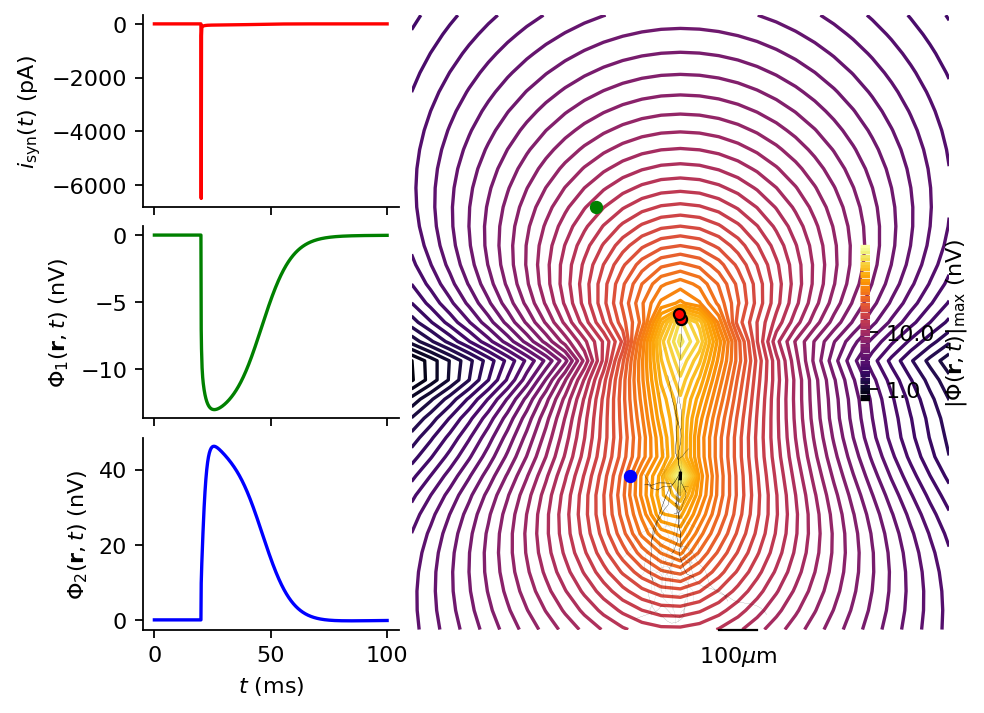

In [8]:
run_expr(int_parameters, int_rotations)

In [ ]:
run_expr(pyr_parameters, pyr_rotations)

# <font color= 'red'>Ex 3:</font> Sustainability

Consider the environmental impact of the large-scale computing for computational science. Suggest two ways in which the impact of computing can be reduced, include at least one idea of your own (not covered in the lecture). 

<font size='3'><font color= 'red'>[1 pts]</font> 


<span style="color:purple">
<font size='3'> 
    

## **Grading**: 
 - 0.5 pt per suggestion (we will be very lenient in the accepted answers, just make an effort to come up with options and you'll get the points).
    

[/2 pt]    
</span>